# BME 342 - Data Preparation

*Victor Ibañez & Lasse Meyer, Bodenmiller Lab, 15.11.2024*

This script can be used as a template for the final project of block course **BME 342, Deep Learning in Biomedicine**. 

**It contains:**
- *Information, guidelines*
- *Imports of many useful packages*
- *Some functions which can be used for preprocessing, image loading and image visualization.*
- *A potential structure for the project*

**Here is a guideline for the project that can be (but not has to be!) considered and may be helpful:**

Preliminary EDA & data cleaning:
-	Read about the data type
-	Investigate data & plot class distribution

Preprocessing:
-	Normalization ✓
-	Transformation X
-	Data augmentation X --> later
-	Up-/downsampling X 
-	Channel reduction (✓)
-	Image Resizing ? --> later ? 
-	Label preparation --> correct ?  

Model architecture:
-	NNs, CNNs, Transformers, ABMILs, etc.
    
    CNN

Training framework:
-	Train-/test split
-	Different optimizers
-	Different loss functions
-	Different metrics
-	Cross validation
-	Early Stopping
-	Learning rate scheduler

Data management:
-	Generator from file path or CPU
-	Disable GPU (if not enough RAM on GPU)

Training log & Results visualization:
-	Plot training and validation process
-	Log training history
-	Plot Confusion matrix

**Keep in mind when working with jupyter notebooks:**
- Come up with a clear and concise structure of your project
- Comment your working steps by changing the cell to Markdown
- Use blocks for single code logic (at least try to)
- Include plots & other visualizations; this is the advantage of using notebooks!

But most importantly... happy coding! &#128512;

### Initialize Notebook

In [2]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-20 10:56:24.370414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 10:56:24.385224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 10:56:24.389741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 10:56:24.400238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...


I0000 00:00:1734692186.970240  610380 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.17.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.7.0

End checks and initialization.


I0000 00:00:1734692187.012115  610380 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734692187.015888  610380 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734692187.022093  610380 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734692187.025639  610380 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

In [4]:
# Preprocessing (if needed)
def preprocessing(image, transpose=True, normalize=True) -> np.ndarray:
    if transpose:
        return np.transpose(image, (1, 2, 0))
    if normalize:
        return IMCPreprocessor.normalize_multichannel_image(image)

In [5]:
# Load images
def load_image(image_path) -> np.ndarray:
    image = tiff.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return image


# Define a function to create a list of images from files within a folder 
def image_list(image_dir):
    # List all files in the directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]  
    # Initialize a list to store the images
    images = []
    # Loop through each file and read the image
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        image = load_image(image_path)
        images.append(image)        
    return images 


In [6]:

# # Extract channel information
# panel_df = pd.read_csv('panel.csv')
# channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

# # change 'your_image_array' to your actual array name that contains the images
# img_nb = 1
# channel_to_display = ['Yb173'] # choose a channel to display
# plt.imshow(IMCPreprocessor.drop_channels(your_image_array[img_nb], channel_to_display, list(channel_names.values()))[0], cmap='gray')
# plt.title(f"{channel_to_display[0]} - channel")
# plt.axis('off')
# plt.show()


## Load & preprocess images

Get Folder Directory

In [7]:
folder_directory = os.getcwd()
print(folder_directory)

/home/jupyter-rohimm/FinalProject/code


Inspect Folder Elements of IMC_images

In [8]:
images_dir = '../IMC_images' 
metadata_dir = '../metadata.csv' 
panel_dir = '../panel.csv' 
print(os.listdir(images_dir)[:5]) # Get first five images
print("Number of Images: ",len(os.listdir(images_dir))) # Get number of images in Dataset

['ZTMA224.1_BlockB_SE_123.tiff', 'ZTMA224.1_BlockC_SE_098.tiff', 'ZTMA224.1_BlockB_SE_020.tiff', 'ZTMA20.4_Block1_SE_012.tiff', 'ZTMA224.1_BlockA_SE_003.tiff']
Number of Images:  984


Load images and labels

In [9]:
# Load images
images = image_list(images_dir)
# load labels
# PDL1
metadata = pd.read_csv(metadata_dir)
PDL1_score = metadata["PDL1_score"]


In [10]:
images = np.array(images)

In [11]:
PDL1_score = PDL1_score.tolist()

How many images & Shapes

In [12]:
# length of images in the list
print("Length of list with images:", len(images))
# Length of PDL1_score labels
print("Length of list with images:", len(PDL1_score))
# Shape of the individual images
print("Shape of the 1st image:", images[0].shape) # 46 Channel, 224 (x) * 224 (y) pixels
# Data type 
print("Data type of 1st image:", images[0].dtype)

Length of list with images: 984
Length of list with images: 984
Shape of the 1st image: (46, 224, 224)
Data type of 1st image: float32


Need to preprocess the image in order to used drop_channels method! Transpose the array to get correct shape

shape (channels, x, y) --> (x, y, channels)

Also normalizing

Plot 1st image with the 42 channels

In [13]:
first_image = images[0]
first_image_transposed = preprocessing(first_image, transpose=True, normalize=False) 
first_image_transposed_normalized = preprocessing(first_image_transposed, transpose=False, normalize=True) 

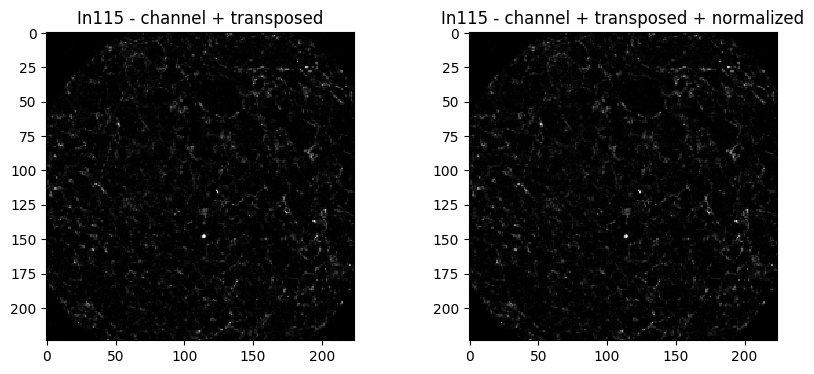

In [14]:
# Extract channel information
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

# change 'your_image_array' to your actual array name that contains the images
# img_nb = 0
channel_to_display = ['In115'] # choose a channel to display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(IMCPreprocessor.drop_channels(first_image_transposed, channel_to_display, list(channel_names.values()))[0], interpolation = "none", cmap='grey')
ax1.set_title(f"{channel_to_display[0]} - channel + transposed")
ax1.axis("on")
ax2.imshow(IMCPreprocessor.drop_channels(first_image_transposed_normalized, channel_to_display, list(channel_names.values()))[0], interpolation = "none", cmap='grey')
ax2.set_title(f"{channel_to_display[0]} - channel + transposed + normalized")
ax2.axis("on")
plt.show()

In [15]:
print(np.mean(first_image_transposed))
print(np.mean(first_image_transposed_normalized))

print(np.std(first_image_transposed))
print(np.std(first_image_transposed_normalized))

print(np.max(first_image_transposed))
print(np.max(first_image_transposed_normalized))

print(np.min(first_image_transposed))
print(np.min(first_image_transposed_normalized))

1.9663248
0.045792855
7.926831
0.10775336
155.44931
1.0
0.0
0.0


Plotting all 46 channels for first image transpoed and normalized

Channels Xe131 and Xe134 seem very noisy --> investigate for all images 

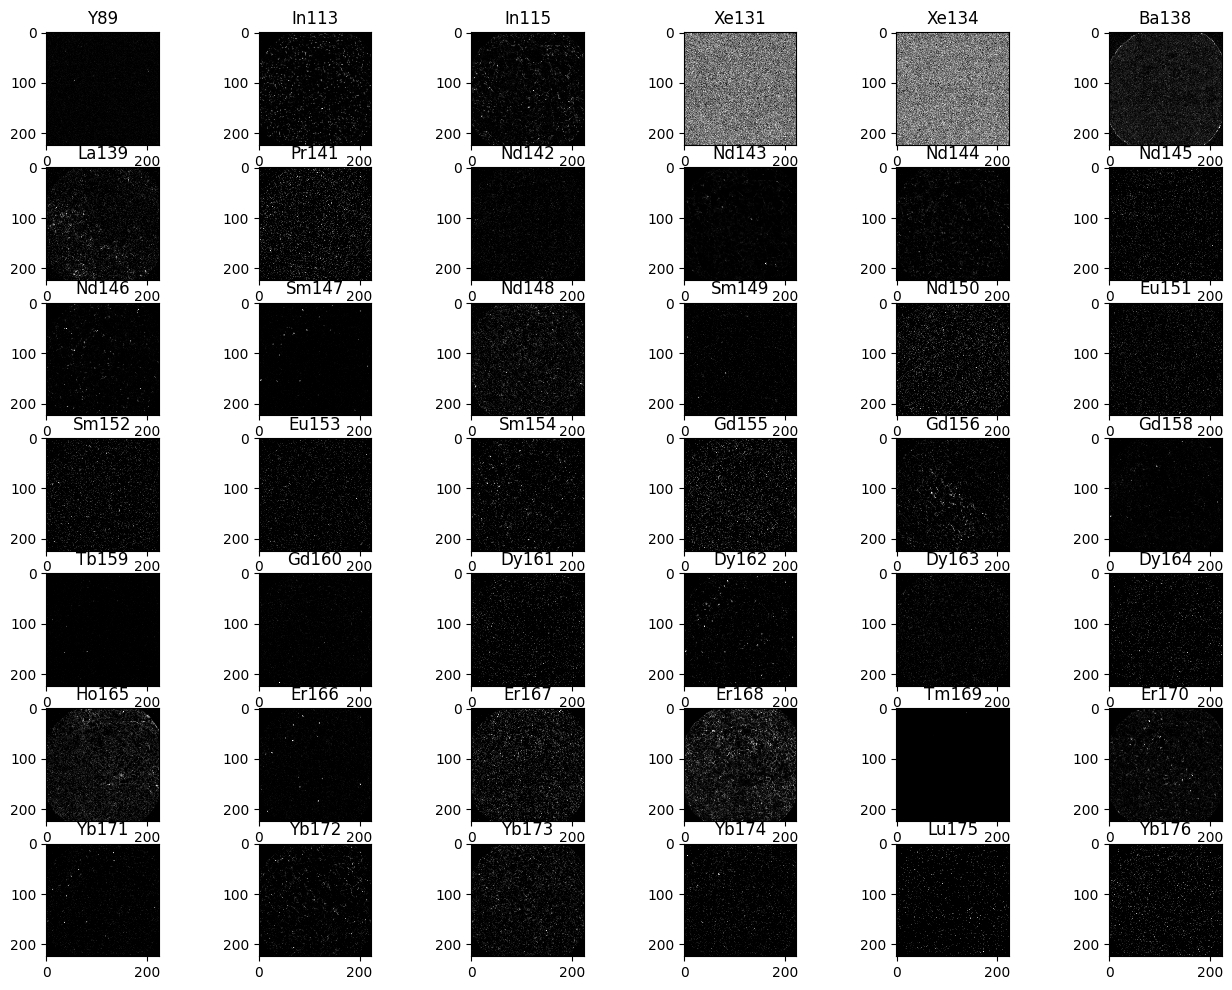

In [16]:

fig=plt.figure(figsize=(16, 12))
columns = 6
rows = 7
# first_image = images[0]
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(first_image[i-1], interpolation = "none", cmap = "grey")
    plt.title(list(channel_names.values())[i-1])
plt.savefig("dataset_images/allchannels.png")
plt.show()


In [17]:
# Preprocessing all the images: Transpose
images_preproc = [preprocessing(i, transpose = True, normalize = False) for i in images]
# images_preproc = [preprocessing(i, transpose = False, normalize = True) for i in images_preproc]

In [18]:
images_preproc = np.array(images_preproc)

In [19]:
images_preproc.shape

(984, 224, 224, 46)

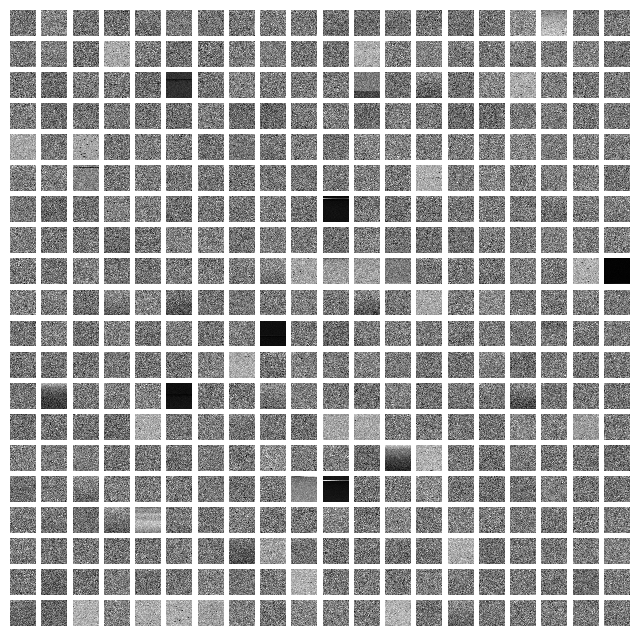

In [20]:

channel_to_display = ['Xe131', "Xe134"] # choose a channel to display
fig=plt.figure(figsize=(8,8))
columns = 20
rows = 20
# first_image = images[0]
# Display Channel Xe131 for first 400 images
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(IMCPreprocessor.drop_channels(images_preproc[i-1], [channel_to_display[0]], list(channel_names.values()))[0], interpolation = "none", cmap='grey')
    plt.axis("off")
plt.show()

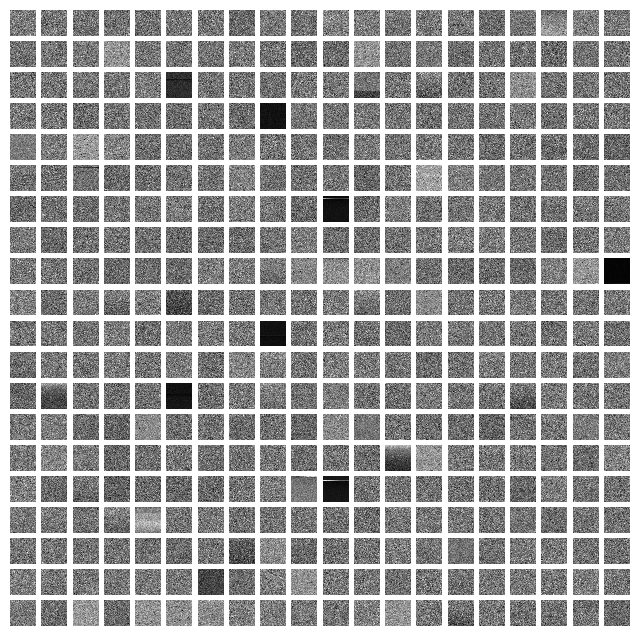

In [21]:
# Plot Xe134 Channel for first 400 images
fig=plt.figure(figsize=(8,8))
columns = 20
rows = 20
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(IMCPreprocessor.drop_channels(images_preproc[i-1], [channel_to_display[1]], list(channel_names.values()))[0], interpolation = "none", cmap='grey')
    plt.axis("off")
plt.show()

## EDA & Data Cleaning

For both Xe131 and Xe134, the whole data sets seems to be very noisy --> filter it out for the **time being**


In [22]:
channel_names_new = [x for x in list(channel_names.values()) if x not in ["Xe131", "Xe134"]]

In [23]:
# Drop Channels: Xe131 and Xe134
images_preproc_drop = [IMCPreprocessor.drop_channels(i, channel_names_new, list(channel_names.values()))[0] for i in images_preproc]
channels_preproc_drop = channel_names_new

In [24]:
images_preproc_drop = np.array(images_preproc_drop) # Only 44 channel now --> Xe131 and Xe134 successfully dropped

In [25]:
images_preproc_drop.shape

(984, 224, 224, 44)

##### EDA: Assess PDL1 Distribution

Stratified Shuffle is necessary to attain a balanced setting! 

In [26]:
PDL1_score = np.array(PDL1_score)

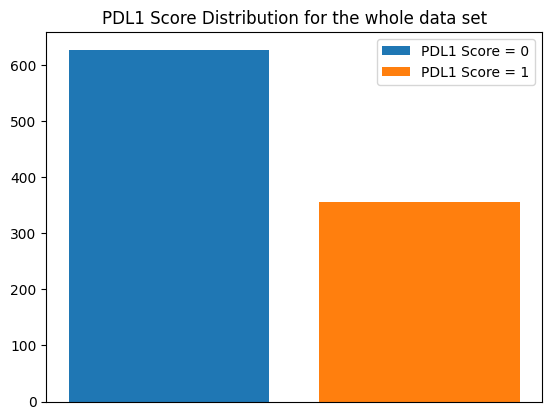

In [27]:
PDL1_1 = PDL1_score[np.where(PDL1_score == 0)].shape[0]
PDL1_2 = PDL1_score[np.where(PDL1_score == 1)].shape[0]
n = PDL1_1 + PDL1_2
plt.bar(0, PDL1_1, label = 'PDL1 Score = 0')
plt.bar(1, PDL1_2, label = 'PDL1 Score = 1')
plt.legend()
plt.title("PDL1 Score Distribution for the whole data set")
plt.gca().get_xaxis().set_visible(False)
plt.savefig("dataset_images/PD-L1_distribution.png")
plt.show()


#### Baseline Accuracy


In [28]:
baseline_accuracy = 100*np.max([PDL1_1/n, PDL1_2/n])
print("Baseline accuracy is {:.2f} %".format(baseline_accuracy))

Baseline accuracy is 63.82 %


In [31]:
proportion = PDL1_1/n * 100
print(f"PD-L1 Positive: {proportion:.2f}%\t Negative: {100-proportion:.2f}%")

PD-L1 Positive: 63.82%	 Negative: 36.18%


## Load & Filter dataframe

#### ResNet50 for 3 Channels

In [37]:
# Choose 3 random channels to experiment with ResNet50
channel_names_new = ["Gd160", "Yb171", "Dy164"]
images_preproc_drop_3 = [IMCPreprocessor.drop_channels(i, channel_names_new, list(channel_names.values()))[0] for i in images_preproc]
channels_preproc_drop_3 = channel_names_new

In [38]:
images_preproc_drop_3 = np.array(images_preproc_drop_3)

In [30]:
images_preproc_drop_3.shape

(984, 224, 224, 3)

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
random_seed = 56
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=random_seed)
# Perform the split
for test_index, train_index in sss.split(images_preproc_drop_3, PDL1_score):
    X_test, X_train = images_preproc_drop_3[test_index], images_preproc_drop_3[train_index]
    y_test, y_train = PDL1_score[test_index], PDL1_score[train_index]



In [40]:
# Reset y_index 
# y_train = y_train.reset_index(drop = True) # drop true so not to integrate the index into the data frame
for train_index, val_index in sss.split(X_train, y_train):
    X_train, X_val = X_train[val_index], X_train[train_index]
    y_train, y_val = y_train[val_index], y_train[train_index]

# y_train = y_train.reset_index(drop = True) 
# y_test = y_test.reset_index(drop = True) 
# y_val = y_val.reset_index(drop = True) 

In [41]:
# Check dimensions
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_test) + len(X_train) + len(X_val))

631
157
196
984


In [ ]:
X_train.shape
y_train.shape

#### Checking PDL1 Distribution 

All the same proportion 

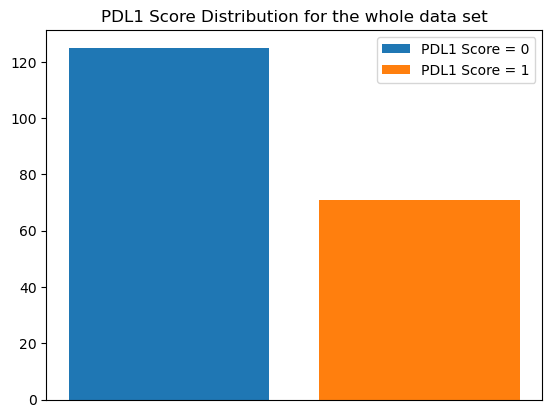

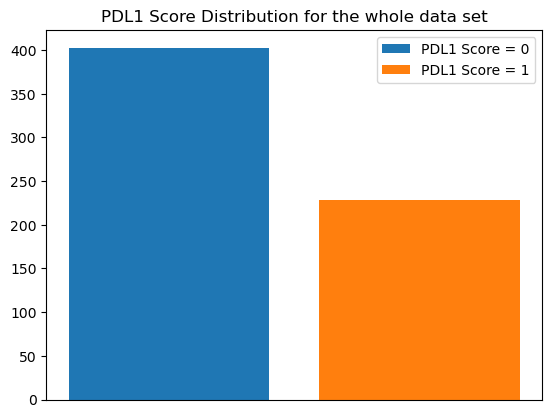

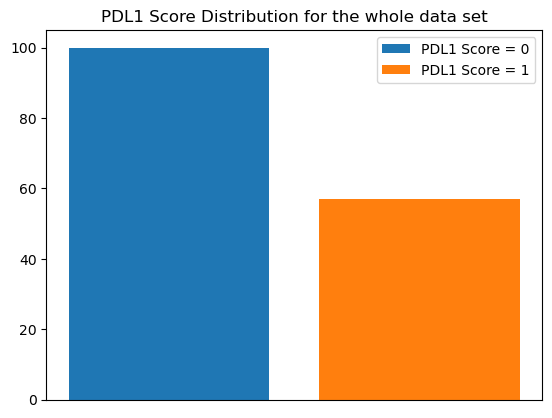

In [42]:
# Check PDL1 Distribution

plt.bar(0, y_test[np.where(y_test == 0)[0]].shape[0], label = 'PDL1 Score = 0')
plt.bar(1, y_test[np.where(y_test == 1)[0]].shape[0], label = 'PDL1 Score = 1')
plt.legend()
plt.title("PDL1 Score Distribution for the whole data set")
plt.gca().get_xaxis().set_visible(False)
plt.show()

plt.bar(0, y_train[np.where(y_train == 0)[0]].shape[0], label = 'PDL1 Score = 0')
plt.bar(1, y_train[np.where(y_train == 1)[0]].shape[0], label = 'PDL1 Score = 1')
plt.legend()
plt.title("PDL1 Score Distribution for the whole data set")
plt.gca().get_xaxis().set_visible(False)
plt.show()

plt.bar(0, y_val[np.where(y_val == 0)[0]].shape[0], label = 'PDL1 Score = 0')
plt.bar(1, y_val[np.where(y_val == 1)[0]].shape[0], label = 'PDL1 Score = 1')
plt.legend()
plt.title("PDL1 Score Distribution for the whole data set")
plt.gca().get_xaxis().set_visible(False)
plt.show()

### Building Model: 64x64 images (downsample)

Downsample our images (but make copy first) from 224x224 --> 64x64

In [43]:
# Downsampling
from skimage import io, transform
X_train_64 = [transform.resize(i, (64, 64), anti_aliasing=True) for i in X_train]
X_train_64 = np.array(X_train_64)
X_test_64 = [transform.resize(i, (64, 64), anti_aliasing=True) for i in X_test]
X_test_64 = np.array(X_test_64)
X_val_64 = [transform.resize(i, (64, 64), anti_aliasing=True) for i in X_val]
X_val_64 = np.array(X_val_64)

In [65]:
X_train_64.shape

(631, 64, 64, 3)

In [44]:
def convert_to_one_hot(y, classes):
    return np.eye(classes)[y]


#### Define identity block and convolutional block

In [46]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
# from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 2

y_train_one_hot = convert_to_one_hot(y_train, CLASSES)
y_test_one_hot = convert_to_one_hot(y_test, CLASSES)
y_val_one_hot = convert_to_one_hot(y_val, CLASSES)

In [47]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [48]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [49]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [50]:
model_ResNet50 = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

Compile Model 

In [51]:
model_ResNet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
start_time = time.time()

history_ResNet50 = model_ResNet50.fit(X_train_64, y_train_one_hot, epochs = 100, batch_size = 64, validation_data = (X_val_64, y_val_one_hot))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time} seconds")

Epoch 1/100


I0000 00:00:1734096654.799351  605429 service.cc:146] XLA service 0x7f84980b9e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734096654.799390  605429 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-13 13:30:55.531646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-13 13:30:58.153324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


 1/10 ━━━━━━━━━━━━━━━━━━━━ 6:18 42s/step - accuracy: 0.6094 - loss: 0.7373

I0000 00:00:1734096674.959906  605429 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5581 - loss: 2.0163 - val_accuracy: 0.6369 - val_loss: 0.6863
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.6257 - loss: 0.8936 - val_accuracy: 0.6369 - val_loss: 0.6594
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6421 - loss: 0.7211 - val_accuracy: 0.6369 - val_loss: 0.6572
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6516 - loss: 0.6831 - val_accuracy: 0.6369 - val_loss: 0.6600
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6251 - loss: 0.6693 - val_accuracy: 0.6369 - val_loss: 0.6569
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6409 - loss: 0.7060 - val_accuracy: 0.6369 - val_loss: 0.6575
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7999 - loss: 0.4758 - val_accuracy: 0.6369 - val_loss: 0.6689
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8484 - loss: 0.3935 - val_accuracy: 0.6369 - val_l

In [53]:
model_ResNet50.evaluate(X_test_64, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.4946 - loss: 3.5779


[3.334639310836792, 0.5204081535339355]

Saving Model and Model History

In [ ]:
import pickle

# Save the Histoy of ResNet50
with open('./models/history_ResNet50.pkl', 'wb') as f:
    pickle.dump(history_ResNet50.history, f)

# Save model ResNet50
model_ResNet50.save('./models/model_ResNet50.keras')

In [91]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 15,    │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 15, 15,    │      4,160 │ max_pooling2d_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 15, 15,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 15, 15,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 15, 15,    │     36,928 │ activation_50[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 15, 15,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 15, 15,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 15, 15,    │     16,640 │ activation_51[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 15, 15,    │     16,640 │ max_pooling2d_1[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 15, 15,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 15, 15,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 15, 15,    │          0 │ bn2a_branch2c[0]

 Total params: 70,669,192 (269.58 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,077,382 (179.59 MB)

#### COMMENTS

Observing our validation and testing accuracy, our model is performing very badly on the test set while overfitting to the training set. 

2 possible errors contributing to that: 
    1. Downsampling of images from 224x224 to 64x64 --> loss of information 
    2. Uninformative channels used 

Approaches to solve issues:
    1. Problem: 
        - Just use 224x224 pixel images
        - Use Dimensionality reduction techniques to reduce the size of the images (e.g. autoencoders)
    2. Problem: 
        - Access the most significant channels by first apply
            a) Shallow CNNs (per channel or with all channels) and then analyzing
                - SHAP
            b) Autoencoders